In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

while 'notebooks' in os.getcwd():
    os.chdir('..')

import torch
import torch_geometric.transforms as T
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
from sklearn.metrics import roc_auc_score
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
import numpy as np
import pandas as pd

from src.torch_geo_models import GraphSAGE, LinkPredictor
from src.data.gamma.positional_pubmed import load_dataset, get_train_val_test_edges_auc,\
    get_val_test_edges_link_pred, prepare_adjencency, get_edge_index_from_adjencency
from src.train.positional_omega.graph_sage import PositionalOmegaGraphSageCosSim

/home/caiolmartinelli/.cache/pypoetry/virtualenvs/arxiv-paperclassification-f16XUvnj-py3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
logging.basicConfig(
    format='%(asctime)s - %(levelname)s : %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
    filename='logs/omega_function/pubmed/01-1-positional_omega_graph_sage_cossim.log'
)

In [5]:
torch.cuda.is_available()

True

In [6]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)
device

device(type='cuda', index=0)

## Data Loading

In [7]:
dataset = load_dataset()

data, edges_train_auc, edges_val_auc, edges_test_auc =\
    get_train_val_test_edges_auc(dataset, device=device)

data, edges_val, edges_test, neg_edges_val, neg_edges_test =\
    get_val_test_edges_link_pred(data, remove_from_data=True, device=device)

data = prepare_adjencency(data, to_symmetric=True)

edge_index = get_edge_index_from_adjencency(data, device)

Processing...
Done!


## Training

In [8]:
for run in range(30):
    for n_layers in range(1, 4):
        omega = PositionalOmegaGraphSageCosSim(
            device=device,
            num_nodes=data.num_nodes,
            dataset='pubmed',
            n_layers=n_layers,
            run=run)
        torch.cuda.empty_cache()
        omega.train(edge_index,
                    edges_val,
                    edges_test,
                    neg_edges_val,
                    neg_edges_test,
                    edges_train_auc,
                    edges_val_auc,
                    edges_test_auc,
                    data.adj_t,
                    data.y)
        omega.discard_run_not_optimal_models()

## Results

### For a layer number

In [9]:
n_layers = 1

In [10]:
metrics = PositionalOmegaGraphSageCosSim.read_metrics(
    n_layers=n_layers,
    dataset='pubmed'
)
print(metrics.shape)
metrics.head()

(6030, 9)


,n_layers,run,epoch,loss_train,loss_val,loss_test,auc_train,auc_val,auc_test
0,1,0,0,None,1.622669,1.622634,0.507944,0.495515,0.526741
1,1,0,1,1.6226896047592163,1.608472,1.608551,0.512842,0.474923,0.525314
2,1,0,2,1.608620285987854,1.586013,1.586329,0.512061,0.469361,0.526344
3,1,0,3,1.586366891860962,1.553332,1.553980,0.512274,0.466065,0.526361
4,1,0,4,1.5540578365325928,1.509691,1.510702,0.511955,0.463523,0.525910


### Sumarize metrics per epoch

In [11]:
metrics_cols = metrics.columns[3:]
metrics_cols

Index(['loss_train', 'loss_val', 'loss_test', 'auc_train', 'auc_val',
       'auc_test'],
      dtype='object')

In [12]:
metrics['loss_train'] = metrics\
    .replace('None', np.nan)\
    ['loss_train']\
    .astype(float)

In [13]:
epoch_metrics = metrics\
    .fillna(-1)\
    .groupby('epoch')\
    [metrics_cols]\
    .agg(['mean', 'std'])
epoch_metrics.columns = [f'{x[0]}_{x[1]}' for x in epoch_metrics.columns]
epoch_metrics.head()

,loss_train_mean,loss_train_std,loss_val_mean,loss_val_std,loss_test_mean,loss_test_std,auc_train_mean,auc_train_std,auc_val_mean,auc_val_std,auc_test_mean,auc_test_std
epoch,,,,,,,,,,,,
0,-1.000000,0.000000,1.622310,0.000582,1.622341,0.000554,0.511330,0.005511,0.513939,0.017179,0.518618,0.013495
1,1.622326,0.000576,1.607272,0.002093,1.607462,0.002000,0.514447,0.002955,0.483435,0.008508,0.526422,0.006963
2,1.607356,0.002076,1.583320,0.004865,1.583803,0.004644,0.514371,0.002687,0.479722,0.007659,0.525560,0.005293
3,1.583579,0.004820,1.548465,0.008877,1.549386,0.008492,0.513852,0.002635,0.477933,0.008085,0.524115,0.004558
4,1.548940,0.008812,1.502260,0.013563,1.503681,0.012978,0.513399,0.002579,0.476550,0.008901,0.522779,0.004420


In [14]:
epoch_metrics.sort_values('auc_val_mean', ascending=False).head()

,loss_train_mean,loss_train_std,loss_val_mean,loss_val_std,loss_test_mean,loss_test_std,auc_train_mean,auc_train_std,auc_val_mean,auc_val_std,auc_test_mean,auc_test_std
epoch,,,,,,,,,,,,
0,-1.000000,0.000000,1.622310,0.000582,1.622341,0.000554,0.511330,0.005511,0.513939,0.017179,0.518618,0.013495
87,0.933269,0.002581,0.925254,0.004897,0.920525,0.004923,0.546470,0.002942,0.500335,0.006129,0.565650,0.005533
86,0.935393,0.002334,0.927131,0.004923,0.922424,0.004942,0.546556,0.002971,0.500319,0.006180,0.565691,0.005547
85,0.937111,0.002689,0.929020,0.004932,0.924326,0.004959,0.546634,0.002995,0.500314,0.006186,0.565714,0.005542
88,0.931649,0.002481,0.923385,0.004867,0.918634,0.004905,0.546379,0.002913,0.500307,0.006091,0.565605,0.005536


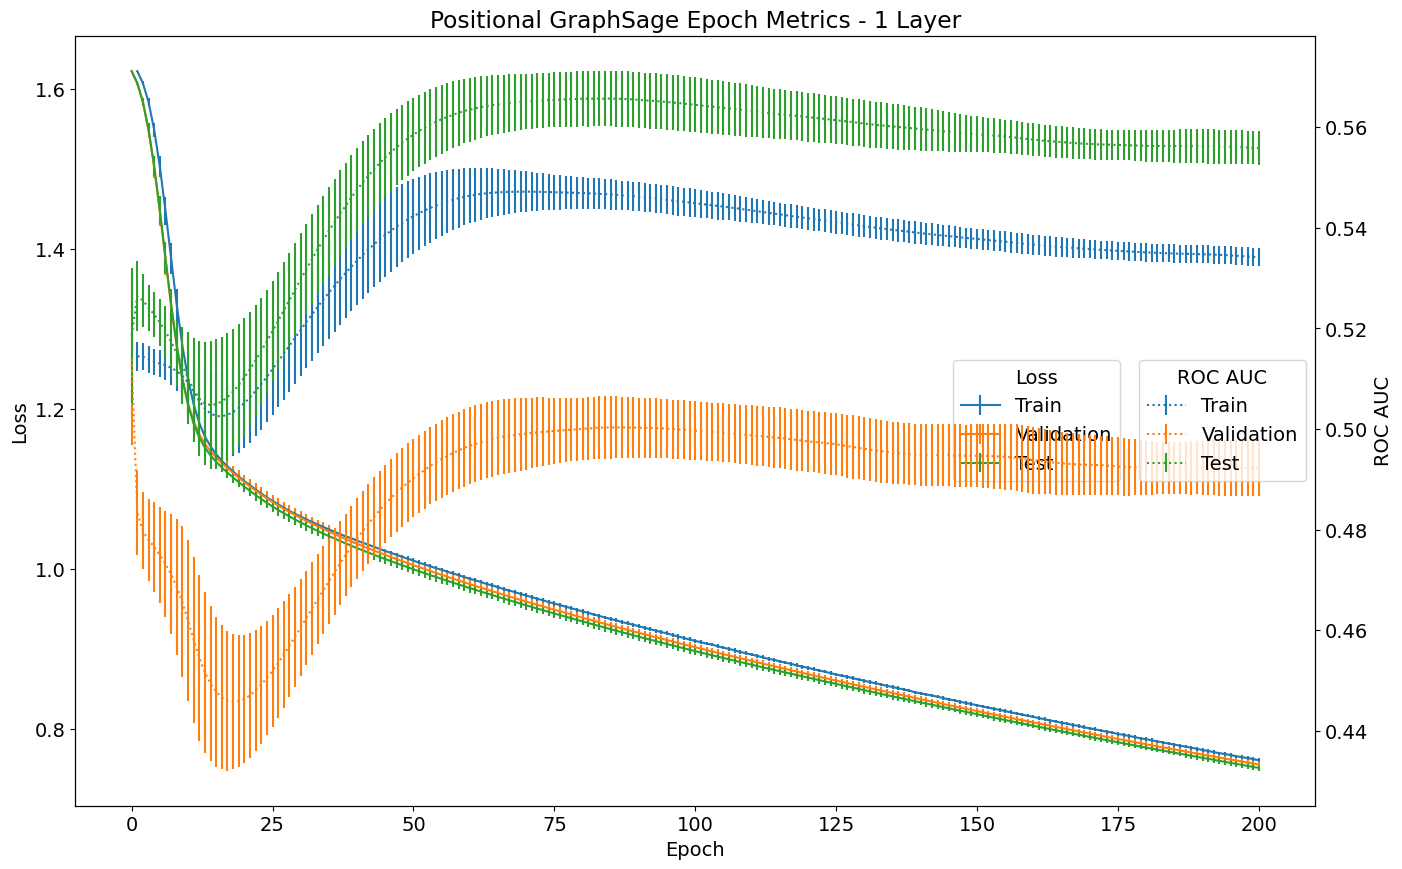

In [16]:
plt.rcParams['font.size'] = '14'
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))

ax1.set_title(f'Positional GraphSage Epoch Metrics - {n_layers} Layer')

ax1.errorbar(
    epoch_metrics.index[1:],
    epoch_metrics['loss_train_mean'][1:],
    yerr=epoch_metrics['loss_train_std'][1:],
    ls='-',
    label='Train')

ax1.errorbar(
    epoch_metrics.index,
    epoch_metrics['loss_val_mean'],
    yerr=epoch_metrics['loss_val_std'],
    ls='-',
    label='Validation')

ax1.errorbar(
    epoch_metrics.index,
    epoch_metrics['loss_test_mean'],
    yerr=epoch_metrics['loss_test_std'],
    ls='-',
    label='Test')

ax1.legend(loc='center right', title='Loss', bbox_to_anchor=[0.85, 0.5])
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')

ax2 = ax1.twinx()

ax2.errorbar(
    epoch_metrics.index[1:],
    epoch_metrics['auc_train_mean'][1:],
    yerr=epoch_metrics['auc_train_std'][1:],
    ls=':',
    label='Train')

ax2.errorbar(
    epoch_metrics.index,
    epoch_metrics['auc_val_mean'],
    yerr=epoch_metrics['auc_val_std'],
    ls=':',
    label='Validation')

ax2.errorbar(
    epoch_metrics.index,
    epoch_metrics['auc_test_mean'],
    yerr=epoch_metrics['auc_test_std'],
    ls=':',
    label='Test')

ax2.legend(loc='center right', title='ROC AUC', bbox_to_anchor=[1, 0.5])
ax2.set_ylabel('ROC AUC')

plt.savefig(f'reports/images/pubmed/positional_omega_graphsage_cossim_training_metrics_{n_layers}layers.pdf')

### Comparing Validation Performance for All Layer numbers

In [17]:
n_layers_list = range(1, 4)

In [20]:
mean_auc_val_dict = {}
mean_loss_val_dict = {}
std_auc_val_dict = {}
std_loss_val_dict = {}
for n_layers in n_layers_list:
    metrics = PositionalOmegaGraphSageCosSim.read_metrics(dataset='pubmed', n_layers=n_layers)
    mean_df = metrics.groupby(['epoch'])[['auc_val', 'loss_val']].mean()
    
    auc_val = mean_df['auc_val']
    loss_val = mean_df['loss_val']
    mean_auc_val_dict[n_layers] = auc_val
    mean_loss_val_dict[n_layers] = loss_val

    std_df = metrics.groupby(['epoch'])[['auc_val', 'loss_val']].std()

    auc_val = std_df['auc_val']
    loss_val = std_df['loss_val']
    std_auc_val_dict[n_layers] = auc_val
    std_loss_val_dict[n_layers] = loss_val

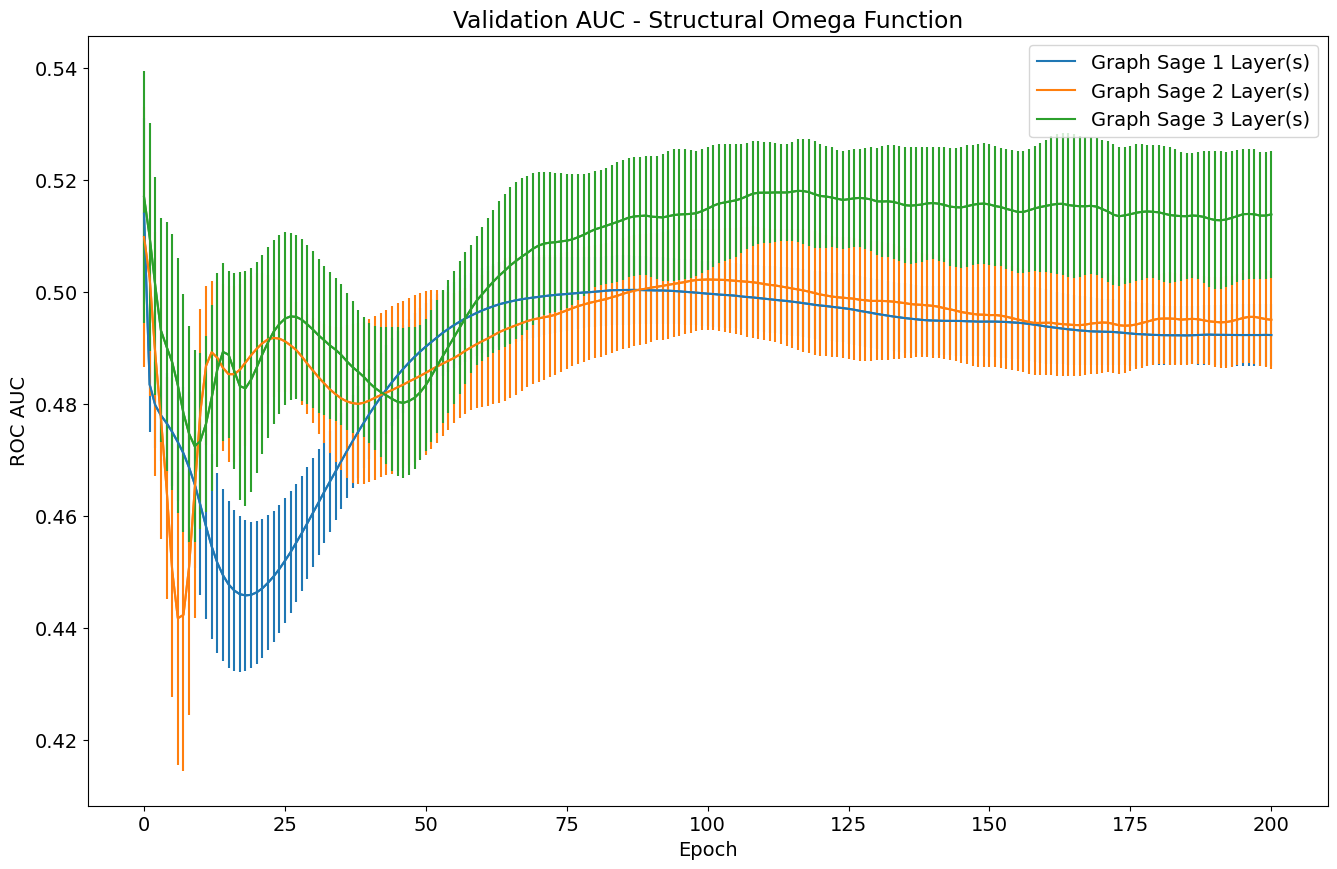

In [21]:
plt.rcParams['font.size'] = '14'
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))

ax1.set_title('Validation AUC - Structural Omega Function')

for n_layers in mean_auc_val_dict:
    error_bar = ax1.errorbar(
        mean_auc_val_dict[n_layers].index,
        mean_auc_val_dict[n_layers],
        yerr=std_auc_val_dict[n_layers],
        ls='-',
        # label=f'Graph Sage {n_layers} Layer(s)',
    )

    color = error_bar[0].get_color()

    ax1.plot(
        mean_auc_val_dict[n_layers].index,
        mean_auc_val_dict[n_layers],
        # yerr=std_auc_val_dict[n_layers],
        ls='-',
        label=f'Graph Sage {n_layers} Layer(s)',
        color=color,
    )

# ax1.set_xlim(-50, 5000)

ax1.set_xlabel('Epoch')
ax1.set_ylabel('ROC AUC')

ax1.legend()

In [22]:
error_bar[0].get_color()

'#2ca02c'

## Score Best model

In [23]:
best_model_metrics = metrics.sort_values('auc_val', ascending=False).iloc[0]
best_model_metrics

n_layers             3
run                 16
epoch                0
loss_train        None
loss_val      1.626304
loss_test     1.626316
auc_train     0.523954
auc_val       0.564458
auc_test      0.543648
Name: 3216, dtype: object

In [25]:
best_model_metrics.to_json('models/positional_omega_graph_sage_cossim/pubmed/best_model_info.json')